<a href="https://colab.research.google.com/github/Shruti0196/Audio_Instrument_Segmentation/blob/main/Audio_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Audio Classification

In [ ]:
!pip install python_speech_features

  Preparing metadata (setup.py) ... done
  Created wheel for python_speech_features: filename=python_speech_features-0.6-py3-none-any.whl size=5870 sha256=a8be9b9707cd62507ba093166951cf7895c075ddb5cfe3df7ea7dc8e3b374319
  Stored in directory: /root/.cache/pip/wheels/5a/9e/68/30bad9462b3926c29e315df16b562216d12bdc215f4d240294
Successfully built python_speech_features


In [ ]:
import os
import librosa
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from python_speech_features import mfcc
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from keras.layers import Conv2D, MaxPool2D, Flatten, Dense, Dropout
from keras.models import Sequential

In [ ]:


# Step 1: Data collection
df = pd.read_csv('/content/drive/MyDrive/DMW Datasets/train.csv')
df.head()


df = df[df['label'].isin(['Cello','Saxophone','Acoustic_guitar','Double_bass', 'Clarinet'])]


path = '/content/drive/MyDrive/DMW Datasets/AudioClass/audio_train/'
audio_data = list()
for i in tqdm(range(df.shape[0])):
    audio_data.append(librosa.load(path+df['fname'].iloc[i]))
audio_data = np.array(audio_data)


df['audio_waves'] = audio_data[:,0]
df['samplerate'] = audio_data[:,1]
df.head()


bit_lengths = list()
for i in range(df.shape[0]):
    bit_lengths.append(len(df['audio_waves'].iloc[i]))
bit_lengths = np.array(bit_lengths)
df['bit_lengths'] = bit_lengths
df['second_lengths'] = df['bit_lengths']/df['samplerate']
df.head()




100%|██████████| 1500/1500 [11:07<00:00,  2.25it/s]
<ipython-input-5-60ba29a3c8be>:13: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  audio_data = np.array(audio_data)


,fname,label,manually_verified,audio_waves,samplerate,bit_lengths,second_lengths
1,001ca53d.wav,Saxophone,1,"[-0.0007318411, -0.0010987374, -0.0010554848, ...",22050,227556,10.32
4,00353774.wav,Cello,1,"[-0.0038409228, -0.0053546177, -0.0044509345, ...",22050,99666,4.52
5,003b91e8.wav,Cello,0,"[0.0032028242, 0.0048782486, 0.0045191115, 0.0...",22050,292824,13.28
8,004ad66f.wav,Clarinet,0,"[-0.00018641094, -0.00029706996, -0.0003078543...",22050,154350,7.0
14,0091fc7f.wav,Cello,1,"[0.0004278731, 0.00058661087, 0.0004574032, 0....",22050,125685,5.7


In [ ]:

# Step 2: Data generation


df = df[df['second_lengths'] >= 2.0]


with open('audio_df.pickle', 'wb') as f:
    pickle.dump(df, f)

with open('audio_df.pickle', 'rb') as f:
    df = pickle.load(f)


min_bits = np.min(df['bit_lengths'])
print(min_bits)
min_seconds = np.min(df['second_lengths'])
print(min_seconds)


num_samples = 6000
generated_audio_waves = list()
generated_audio_labels = list()
for i in tqdm(range(num_samples)):
    try:
        chosen_file = np.random.choice(df['fname'].values)
        chosen_initial = np.random.choice(np.arange(0,df[df['fname']==chosen_file]['bit_lengths'].values-min_bits))
        generated_audio_waves.append(df[df['fname']==chosen_file]['audio_waves'].values[0][chosen_initial:chosen_initial+min_bits])

        generated_audio_labels.append(df[df['fname']==chosen_file]['label'].values)
    except ValueError:
        continue
generated_audio_waves = np.array(generated_audio_waves)
generated_audio_labels = np.array(generated_audio_labels)

44100
2.0


100%|██████████| 6000/6000 [00:11<00:00, 505.91it/s]


100%|██████████| 5970/5970 [00:51<00:00, 115.20it/s]


(5970, 44100)
(5970, 275, 13)


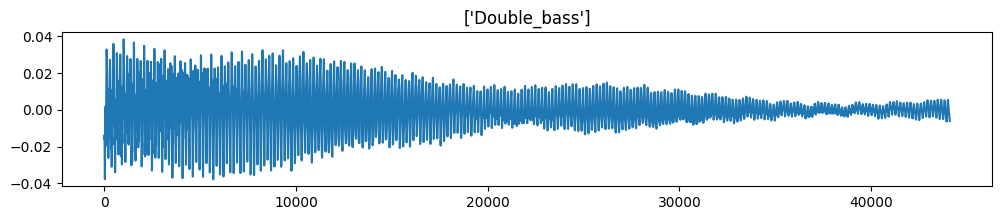

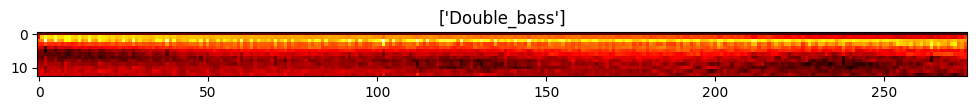

In [ ]:

# Step 3: Features preprocessing
mfcc_features = list()
for i in tqdm(range(len(generated_audio_waves))):
    mfcc_features.append(mfcc(generated_audio_waves[i]))
mfcc_features = np.array(mfcc_features)

print(generated_audio_waves.shape)
print(mfcc_features.shape)


plt.figure(figsize=(12,2))
plt.plot(generated_audio_waves[30])
plt.title(generated_audio_labels[30])
plt.show()


plt.figure(figsize=(12, 2))
plt.imshow(mfcc_features[30].T, cmap='hot')
plt.title(generated_audio_labels[30])
plt.show()

In [ ]:


# Step 4: Label preprocessing

label_encoder = LabelEncoder()
label_encoded = label_encoder.fit_transform(generated_audio_labels)
print(label_encoded)

label_encoded = label_encoded[:, np.newaxis]
print(label_encoded)


one_hot_encoder = OneHotEncoder(sparse=False)
one_hot_encoded = one_hot_encoder.fit_transform(label_encoded)
print(one_hot_encoded)


[2 2 0 ... 0 0 1]
[[2]
 [2]
 [0]
 ...
 [0]
 [0]
 [1]]
[[0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0.]
 [1. 0. 0. 0. 0.]
 ...
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0.]]


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


(4776, 275, 13, 1)
(1194, 275, 13, 1)
Epoch 1/30
150/150 [==============================] - 44s 282ms/step - loss: 1.6162 - acc: 0.2387 - val_loss: 1.5017 - val_acc: 0.3451
Epoch 2/30
150/150 [==============================] - 41s 272ms/step - loss: 1.4112 - acc: 0.3419 - val_loss: 1.2823 - val_acc: 0.3953
Epoch 3/30
150/150 [==============================] - 39s 263ms/step - loss: 1.2872 - acc: 0.4001 - val_loss: 1.2124 - val_acc: 0.4472
Epoch 4/30
150/150 [==============================] - 48s 322ms/step - loss: 1.2018 - acc: 0.4506 - val_loss: 1.1291 - val_acc: 0.4908
Epoch 5/30
150/150 [==============================] - 39s 260ms/step - loss: 1.1514 - acc: 0.4952 - val_loss: 1.0746 - val_acc: 0.5570
Epoch 6/30
150/150 [==============================] - 41s 275ms/step - loss: 1.1017 - acc: 0.5308 - val_loss: 1.0247 - val_acc: 0.6256
Epoch 7/30
150/150 [==============================] - 42s 279ms/step - loss: 1.0513 - acc: 0.5540 - val_loss: 0.9890 - val_acc: 0.6382
Epoch 8/30
150/15

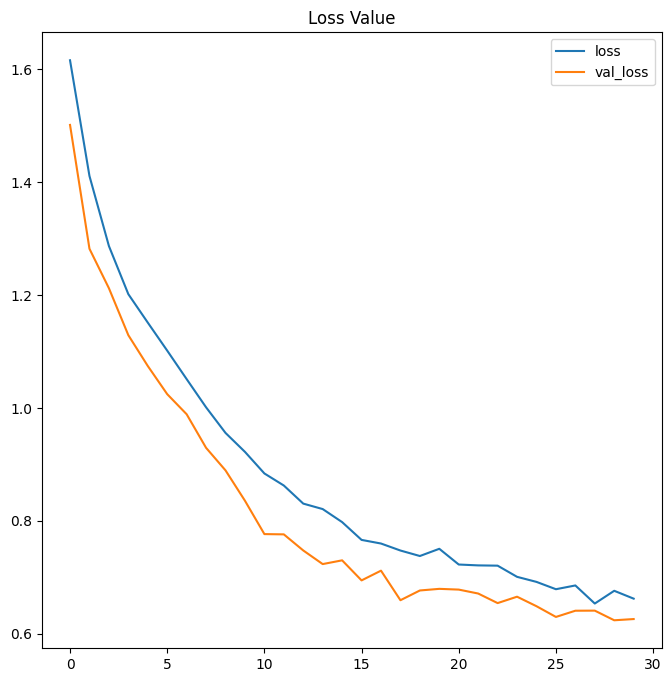

acc: 0.7458124160766602
val_acc: 0.8107202649116516


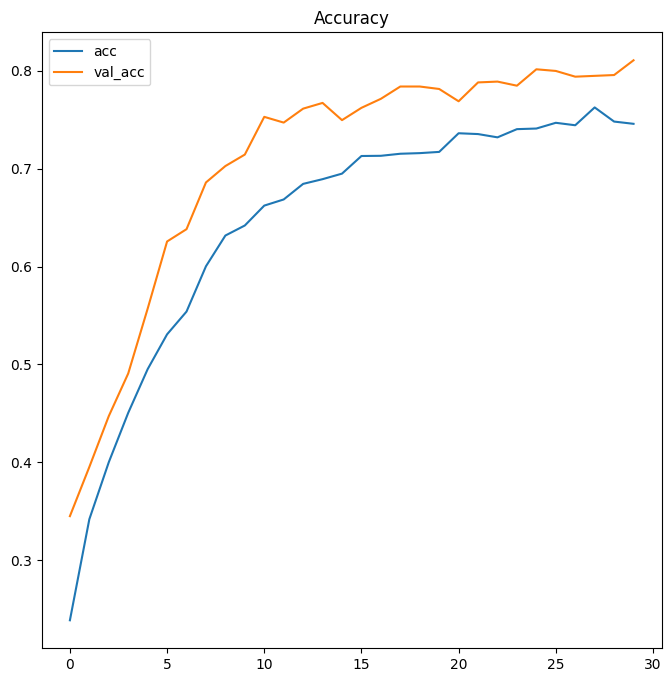

In [ ]:
# Step 5: Model training
X = mfcc_features
y = one_hot_encoded
X = (X-X.min())/(X.max()-X.min())


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)


input_shape = (X_train.shape[1], X_train.shape[2], 1)

X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2], 1)
print(X_train.shape)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2], 1)
print(X_test.shape)

model = Sequential()
model.add(Conv2D(16, (3, 3), activation='relu', strides=(1, 1),
    padding='same', input_shape=input_shape))
model.add(Conv2D(32, (3, 3), activation='relu', strides=(1, 1),
    padding='same'))
model.add(MaxPool2D((2, 2)))
model.add(Dropout(0.5))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(5, activation='softmax'))

model.compile(loss='categorical_crossentropy',
     optimizer='adam',
     metrics=['acc'])


history = model.fit(X_train, y_train, epochs=30, validation_data=(X_test, y_test))


plt.figure(figsize=(8,8))
plt.title('Loss Value')
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['loss', 'val_loss'])
print('loss:', history.history['loss'][-1])
print('val_loss:', history.history['val_loss'][-1])
plt.show()


plt.figure(figsize=(8,8))
plt.title('Accuracy')
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.legend(['acc', 'val_acc'])
print('acc:', history.history['acc'][-1])
print('val_acc:', history.history['val_acc'][-1])
plt.show()


38/38 [==============================] - 2s 47ms/step


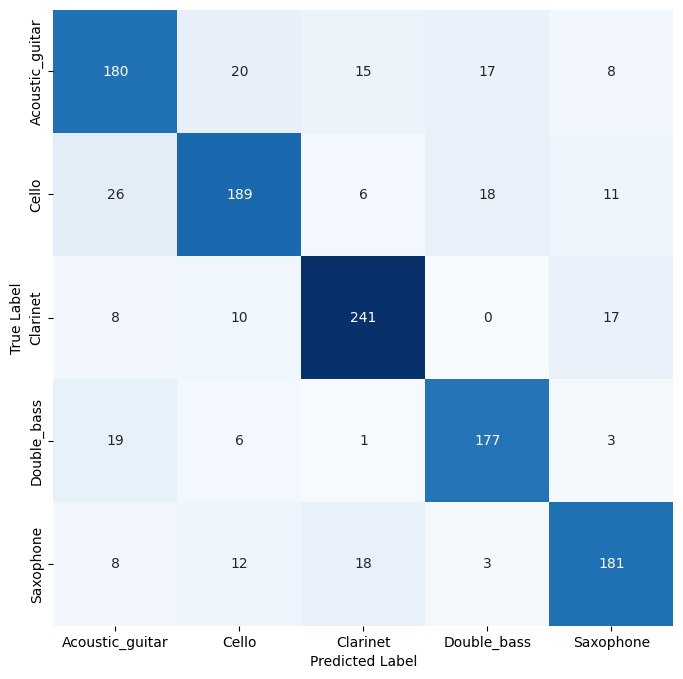

In [ ]:

# Step 6: Model evaluation
predictions = model.predict(X_test)

predictions = np.argmax(predictions, axis=1)
y_test = one_hot_encoder.inverse_transform(y_test)


cm = confusion_matrix(y_test, predictions)
plt.figure(figsize=(8,8))
sns.heatmap(cm, annot=True, xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_, fmt='d', cmap=plt.cm.Blues, cbar=False)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()